# Data Preparation for pretrained i3d kinetics **400**

In [ ]:
import os, cv2, numpy as np, random
from tqdm import tqdm
from PIL import Image, ImageEnhance

# ✅ Final Settings - All Correct
input_root = "/content/drive/MyDrive/Dataset"
output_root = "/content/drive/MyDrive/clips_dataset_32frames_final"
classes = ["Snatching", "Normal"]
num_frames = 32  # ✅ 32 frames per video
val_split = 0.2
os.makedirs(output_root, exist_ok=True)

def simplified_sampling(total_frames, num_samples=32):
    return np.linspace(0, max(0, total_frames-1), num_samples, dtype=int).tolist()

def apply_augmentation(frames, is_training=True):
    """Apply augmentation only to training data"""
    if not is_training:
        return frames

    augmented_frames = []
    # Decide augmentation parameters once for whole video
    do_flip = random.random() < 0.5
    do_brightness = random.random() < 0.3
    brightness_factor = random.uniform(0.7, 1.3)
    do_contrast = random.random() < 0.25
    contrast_factor = random.uniform(0.8, 1.2)
    do_saturation = random.random() < 0.2
    saturation_factor = random.uniform(0.8, 1.2)
    do_rotation = random.random() < 0.15
    rotation_angle = random.uniform(-8, 8)

    for frame in frames:
        pil_frame = Image.fromarray(frame)

        if do_flip:
            pil_frame = pil_frame.transpose(Image.FLIP_LEFT_RIGHT)
        if do_brightness:
            enhancer = ImageEnhance.Brightness(pil_frame)
            pil_frame = enhancer.enhance(brightness_factor)
        if do_contrast:
            enhancer = ImageEnhance.Contrast(pil_frame)
            pil_frame = enhancer.enhance(contrast_factor)
        if do_saturation:
            enhancer = ImageEnhance.Color(pil_frame)
            pil_frame = enhancer.enhance(saturation_factor)
        if do_rotation:
            pil_frame = pil_frame.rotate(rotation_angle, fillcolor=(128, 128, 128))

        augmented_frames.append(np.array(pil_frame))

    return augmented_frames

# ✅ Main Processing Loop
for cls in classes:
    in_dir = os.path.join(input_root, cls)
    videos = sorted(os.listdir(in_dir))
    random.shuffle(videos)
    split_idx = int(len(videos)*(1-val_split))
    train_videos = videos[:split_idx]
    val_videos = videos[split_idx:]

    for split, vids in (("train", train_videos), ("val", val_videos)):
        out_dir = os.path.join(output_root, split, cls)
        os.makedirs(out_dir, exist_ok=True)
        print(f"Processing {len(vids)} videos for {split}/{cls} (32 frames, normalized)")

        for vid in tqdm(vids):
            path = os.path.join(in_dir, vid)
            cap = cv2.VideoCapture(path)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            indices = simplified_sampling(total_frames, num_frames)

            frames = []
            i = 0
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                if i in indices:
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frame_resized = cv2.resize(frame_rgb, (224,224))  # ✅ 224x224
                    frames.append(frame_resized)
                i += 1
            cap.release()

            if len(frames) == 0:
                print("empty?", path)
                continue

            # Padding if needed
            while len(frames) < num_frames:
                frames.append(frames[-1].copy())

            # ✅ Apply augmentation (only for training)
            is_training = (split == "train")
            augmented_frames = apply_augmentation(frames, is_training)

            # ✅ Convert to float32 and normalize to [0,1]
            clip = np.stack(augmented_frames, axis=0).astype(np.float32)  # (32, 224, 224, 3)
            clip = clip / 255.0  # Convert to [0,1]

            # ✅ Apply ImageNet normalization
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            clip = (clip - mean) / std

            # ✅ Convert to I3D format: (3, 32, 224, 224)
            clip = np.transpose(clip, (3, 0, 1, 2)).astype(np.float32)

            name = os.path.splitext(vid)[0]
            np.save(os.path.join(out_dir, f"{name}.npy"), clip)

print("✅ FINAL PIPELINE COMPLETE!")
print("Ready for I3D training with perfect format!")




```
# This is formatted as code
```

Training **Code**

In [ ]:
# === 1. Imports ===
import os, random, time
from glob import glob
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
)
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# === 2. Dataset (MODIFIED for .pt files and flexible class mapping) ===
class PtClipDataset(Dataset):
    # Mapping the folder names (keys) to the model class index (values)
    # Based on your folder structure (person, snatcher, victim) and your 2 target classes (Snatching, Normal)
    CLASS_MAP = {
        "person": 1,     # Assuming 'person' folder contains 'Normal' clips (index 1)
        "snatcher": 0,   # Assuming 'snatcher' folder contains 'Snatching' clips (index 0)
        "victim": 0      # Assuming 'victim' folder contains 'Snatching' clips (index 0)
    }
    
    def __init__(self, root, split="TRAINDATA"): # split default changed to match your folder
        self.samples = []
        
        # Get all relevant class folders inside the split directory
        split_path = os.path.join(root, split)
        if not os.path.isdir(split_path):
            print(f"Error: Split directory not found at {split_path}")
            return

        # Iterate only over the folders we've defined a mapping for
        for folder_name, class_index in self.CLASS_MAP.items():
            folder = os.path.join(split_path, folder_name)
            if not os.path.isdir(folder):
                print(f"Warning: Class folder not found at {folder}")
                continue
            
            # 🔥 Change 1: Search for "*.pt" files instead of "*.npy"
            for f in glob(os.path.join(folder, "*.pt")):
                self.samples.append((f, class_index))
        
        random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        
        # 🔥 Change 2: Use torch.load() instead of np.load()
        # Load the PyTorch tensor clip
        # Using map_location='cpu' to avoid loading everything to GPU memory if only one worker is used
        clip = torch.load(path, map_location='cpu').float()  # (C, T, H, W) tensor
        
        return clip, label

# === 3. Load pretrained I3D ===
num_classes = 2 
model = torch.hub.load("facebookresearch/pytorchvideo", "i3d_r50", pretrained=True)

# ✅ Replace last layer
model.blocks[6].proj = nn.Linear(model.blocks[6].proj.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# === 4. Training setup (PATH/CLASS/DATASET CHANGES APPLIED) ===
# ----------------------------------------------------------------------
# 🔥 PATH CHANGE APPLIED HERE 🔥
# Set the root directory
data_root = "D:\I3D" 
# Define the final model classes (Snatching=0, Normal=1)
classes = ["Snatching", "Normal"] 

# 🔥 Change 3: Use the new PtClipDataset class and correct split names
# Split names must be "TRAINDATA" and "TESTDATA" to match your disk structure
train_ds = PtClipDataset(data_root, split="TRAINDATA")
val_ds = PtClipDataset(data_root, split="TESTDATA")
# ----------------------------------------------------------------------

print(f"Loaded {len(train_ds)} training samples and {len(val_ds)} validation samples.")
if len(train_ds) == 0:
    raise ValueError("Training dataset is empty. Check your D:\\I3D\\TRAINDATA path and file extensions (.pt).")

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
scaler = GradScaler()

# Early stopping
patience = 10
best_val_f1 = 0.0
no_improve_epochs = 0

# === 5. Training loop ===
for epoch in range(1, 51): 
    epoch_start = time.time()
    print(f"\nEpoch {epoch}/50")

    # --- Train ---
    model.train()
    train_losses, train_preds, train_targs = [], [], []
    for clips, labels in tqdm(train_loader, desc="Training"):
        clips, labels = clips.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(clips)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_losses.append(loss.item())
        train_preds += outputs.argmax(dim=1).cpu().tolist()
        train_targs += labels.cpu().tolist()

    # Train metrics
    train_acc = accuracy_score(train_targs, train_preds)
    train_prec, train_rec, train_f1, _ = precision_recall_fscore_support(
        train_targs, train_preds, average="weighted", zero_division=0
    )

    # --- Validation ---
    model.eval()
    val_losses, val_preds, val_targs, val_probs = [], [], [], []
    with torch.no_grad():
        for clips, labels in tqdm(val_loader, desc="Validation"):
            clips, labels = clips.to(device), labels.to(device)
            outputs = model(clips)
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())
            probs = torch.softmax(outputs, dim=1)
            val_probs += probs.cpu().tolist()
            val_preds += outputs.argmax(dim=1).cpu().tolist()
            val_targs += labels.cpu().tolist()

    # Val metrics (default argmax threshold)
    val_acc = accuracy_score(val_targs, val_preds)
    val_prec, val_rec, val_f1, _ = precision_recall_fscore_support(
        val_targs, val_preds, average="weighted", zero_division=0
    )

    # Log epoch results
    elapsed = time.time() - epoch_start
    print(f"Time: {elapsed:.1f}s")
    print(f" Train Loss: {np.mean(train_losses):.4f} | Acc: {train_acc:.4f} | "
          f"P: {train_prec:.4f} R: {train_rec:.4f} F1: {train_f1:.4f}")
    print(f" Val   Loss: {np.mean(val_losses):.4f} | Acc: {val_acc:.4f} | "
          f"P: {val_prec:.4f} R: {val_rec:.4f} F1: {val_f1:.4f}")

    # --- Save checkpoints ---
    torch.save(model.state_dict(), "last.pt") 
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        no_improve_epochs = 0
        torch.save(model.state_dict(), "aug_data_i3d.pt")
        print(f" 🔥 Saved new best model with F1={best_val_f1:.4f}")
    else:
        no_improve_epochs += 1
        print(f" Patience counter: {no_improve_epochs}/{patience}")
    # Early stopping
    if no_improve_epochs >= patience:
        print("⏹ Early stopping triggered.")
        break

# === 6. Confusion Matrix + Thresholding (post-training) ===
print("\n=== Final Evaluation with Thresholding ===")
model.eval()
all_probs, all_preds, all_labels = [], [], []
with torch.no_grad():
    for clips, labels in tqdm(val_loader, desc="Final Eval"):
        clips, labels = clips.to(device), labels.to(device)
        outputs = model(clips)
        probs = torch.softmax(outputs, dim=1)
        all_probs += probs.cpu().tolist()
        all_labels += labels.cpu().tolist()

# Apply threshold tuning
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Default argmax predictions
default_preds = np.argmax(all_probs, axis=1)

# Threshold tuning: Snatching = 0, Normal = 1
threshold_preds = []
for p in all_probs:
    if p[0] > 0.7: 
        threshold_preds.append(0)
    else:
        threshold_preds.append(1) 

print("\n--- Default Evaluation ---")
print(classification_report(all_labels, default_preds, target_names=classes))
cm = confusion_matrix(all_labels, default_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix - Default Argmax")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\n--- Thresholded Evaluation (Snatching > 0.7) ---")
print(classification_report(all_labels, threshold_preds, target_names=classes))
cm_thr = confusion_matrix(all_labels, threshold_preds)
sns.heatmap(cm_thr, annot=True, fmt="d", cmap="Greens", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix - Thresholded (0.7 for Snatching)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Using cache found in C:\Users\Avijit/.cache\torch\hub\facebookresearch_pytorchvideo_main


Loaded 1013 training samples and 127 validation samples.

Epoch 1/50


Training:   0%|          | 0/126 [00:00<?, ?it/s]

**DAta Preparation for new update dataset 94%->96% accuracy**

In [ ]:
# === 1. Imports ===
import os, random, time
from glob import glob
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
)
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# === 2. Dataset (MODIFIED for .pt files and flexible class mapping) ===
class PtClipDataset(Dataset):
    # Mapping the folder names (keys) to the model class index (values)
    # Snatching=0, Normal=1
    CLASS_MAP = {
        "person": 1,     # Assuming 'person' folder contains 'Normal' clips (index 1)
        "snatcher": 0,   # Assuming 'snatcher' folder contains 'Snatching' clips (index 0)
        "victim": 0      # Assuming 'victim' folder contains 'Snatching' clips (index 0)
    }
    
    def __init__(self, root, split="TRAINDATA"): 
        self.samples = []
        
        # Get all relevant class folders inside the split directory
        split_path = os.path.join(root, split)
        if not os.path.isdir(split_path):
            print(f"Error: Split directory not found at {split_path}")
            return

        # Iterate only over the folders we've defined a mapping for
        for folder_name, class_index in self.CLASS_MAP.items():
            folder = os.path.join(split_path, folder_name)
            if not os.path.isdir(folder):
                print(f"Warning: Class folder not found at {folder}")
                continue
            
            # Searching for "*.pt" files
            for f in glob(os.path.join(folder, "*.pt")):
                self.samples.append((f, class_index))
        
        random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        
        # Using torch.load() for .pt files
        # Using map_location='cpu' to load data outside the main DataLoader worker thread
        clip = torch.load(path, map_location='cpu').float()  # (C, T, H, W) tensor
        
        return clip, label

# === 3. Load pretrained I3D ===
num_classes = 2 
model = torch.hub.load("facebookresearch/pytorchvideo", "i3d_r50", pretrained=True)

# ✅ Replace last layer
model.blocks[6].proj = nn.Linear(model.blocks[6].proj.in_features, num_classes)

# Set device and move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# === 4. Training setup (PATHS and DATASET ARE CORRECT) ===
# ----------------------------------------------------------------------
# Root directory is set to D:\I3D
data_root = "D:\I3D" 
# Define the final model classes 
classes = ["Snatching", "Normal"] 

# Use the PtClipDataset with correct split names
train_ds = PtClipDataset(data_root, split="TRAINDATA")
val_ds = PtClipDataset(data_root, split="TESTDATA")
# ----------------------------------------------------------------------

print(f"Loaded {len(train_ds)} training samples and {len(val_ds)} validation samples.")
if len(train_ds) == 0:
    raise ValueError("Training dataset is empty. Check your D:\\I3D\\TRAINDATA path and file extensions (.pt).")

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
scaler = GradScaler()

# Early stopping
patience = 10
best_val_f1 = 0.0
no_improve_epochs = 0

# === 5. Training loop (Set up for GPU/CUDA with autocast and GradScaler) ===
for epoch in range(1, 51): 
    epoch_start = time.time()
    print(f"\nEpoch {epoch}/50")

    # --- Train ---
    model.train()
    train_losses, train_preds, train_targs = [], [], []
    for clips, labels in tqdm(train_loader, desc="Training"):
        clips, labels = clips.to(device), labels.to(device) # Data moved to GPU
        optimizer.zero_grad()
        with autocast():
            outputs = model(clips)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_losses.append(loss.item())
        train_preds += outputs.argmax(dim=1).cpu().tolist()
        train_targs += labels.cpu().tolist()

    # Train metrics
    train_acc = accuracy_score(train_targs, train_preds)
    train_prec, train_rec, train_f1, _ = precision_recall_fscore_support(
        train_targs, train_preds, average="weighted", zero_division=0
    )

    # --- Validation ---
    model.eval()
    val_losses, val_preds, val_targs, val_probs = [], [], [], []
    with torch.no_grad():
        for clips, labels in tqdm(val_loader, desc="Validation"):
            clips, labels = clips.to(device), labels.to(device) # Data moved to GPU
            outputs = model(clips)
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())
            probs = torch.softmax(outputs, dim=1)
            val_probs += probs.cpu().tolist()
            val_preds += outputs.argmax(dim=1).cpu().tolist()
            val_targs += labels.cpu().tolist()

    # Val metrics (default argmax threshold)
    val_acc = accuracy_score(val_targs, val_preds)
    val_prec, val_rec, val_f1, _ = precision_recall_fscore_support(
        val_targs, val_preds, average="weighted", zero_division=0
    )

    # Log epoch results
    elapsed = time.time() - epoch_start
    print(f"Time: {elapsed:.1f}s")
    print(f" Train Loss: {np.mean(train_losses):.4f} | Acc: {train_acc:.4f} | "
          f"P: {train_prec:.4f} R: {train_rec:.4f} F1: {train_f1:.4f}")
    print(f" Val   Loss: {np.mean(val_losses):.4f} | Acc: {val_acc:.4f} | "
          f"P: {val_prec:.4f} R: {val_rec:.4f} F1: {val_f1:.4f}")

    # --- Save checkpoints ---
    torch.save(model.state_dict(), "last.pt") 
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        no_improve_epochs = 0
        torch.save(model.state_dict(), "aug_data_i3d.pt")
        print(f" 🔥 Saved new best model with F1={best_val_f1:.4f}")
    else:
        no_improve_epochs += 1
        print(f" Patience counter: {no_improve_epochs}/{patience}")
    # Early stopping
    if no_improve_epochs >= patience:
        print("⏹ Early stopping triggered.")
        break

# === 6. Confusion Matrix + Thresholding (post-training) ===
print("\n=== Final Evaluation with Thresholding ===")
model.eval()
all_probs, all_preds, all_labels = [], [], []
with torch.no_grad():
    for clips, labels in tqdm(val_loader, desc="Final Eval"):
        clips, labels = clips.to(device), labels.to(device)
        outputs = model(clips)
        probs = torch.softmax(outputs, dim=1)
        all_probs += probs.cpu().tolist()
        all_labels += labels.cpu().tolist()

# Apply threshold tuning
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Default argmax predictions
default_preds = np.argmax(all_probs, axis=1)

# Threshold tuning: Snatching = 0, Normal = 1
threshold_preds = []
for p in all_probs:
    if p[0] > 0.7: 
        threshold_preds.append(0)
    else:
        threshold_preds.append(1) 

print("\n--- Default Evaluation ---")
print(classification_report(all_labels, default_preds, target_names=classes))
cm = confusion_matrix(all_labels, default_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix - Default Argmax")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\n--- Thresholded Evaluation (Snatching > 0.7) ---")
print(classification_report(all_labels, threshold_preds, target_names=classes))
cm_thr = confusion_matrix(all_labels, threshold_preds)
sns.heatmap(cm_thr, annot=True, fmt="d", cmap="Greens", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix - Thresholded (0.7 for Snatching)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Using cache found in C:\Users\Avijit/.cache\torch\hub\facebookresearch_pytorchvideo_main


Loaded 1013 training samples and 127 validation samples.

Epoch 1/50


Training:   0%|          | 0/126 [00:00<?, ?it/s]

Loading base I3D model architecture...


Using cache found in C:\Users\Avijit/.cache\torch\hub\facebookresearch_pytorchvideo_main


Successfully loaded weights from D:\I3D\SRC\aug_data_i3d.pt
Starting evaluation on 1513 validation samples...


Evaluation: 100%|██████████| 757/757 [03:12<00:00,  3.93it/s]



=== FINAL MODEL PERFORMANCE ANALYSIS ===
Total Evaluation Time: 192.42s
Total Samples: 1513

--- Classification Report (Per-Class Metrics) ---
              precision    recall  f1-score   support

    Snatcher       0.00      0.00      0.00       297
      Victim       0.00      0.00      0.00       425
      Person       0.52      1.00      0.69       791

    accuracy                           0.52      1513
   macro avg       0.17      0.33      0.23      1513
weighted avg       0.27      0.52      0.36      1513


--- Confusion Matrix Data ---
[[  0   0 297]
 [  0   0 425]
 [  0   0 791]]


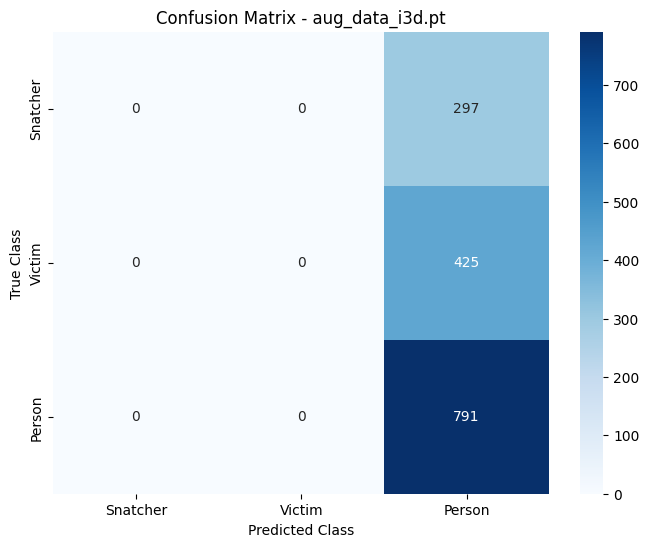

In [2]:
import os, random, time
from glob import glob
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
)
# 🔥 FIX: Ensure tqdm is explicitly imported
from tqdm import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# === 1. Essential Setup (Must match Training Script) ===

# Define the model paths and configuration
MODEL_PATH = "D:\\I3D\\SRC\\aug_data_i3d.pt"
DATA_ROOT = "D:\\I3D"
VAL_SPLIT = "yashtidataset"
num_classes = 3
classes = ["Snatcher", "Victim", "Person"] 
BATCH_SIZE = 2 # Must match the batch size used for stability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Re-define the Dataset class used during training
class PtClipDataset(Dataset):
    CLASS_MAP = {
        "snatcher": 0, "victim": 1, "person": 2
    }
    def __init__(self, root, split="TRAINDATA"): 
        self.samples = []
        split_path = os.path.join(root, split)
        if not os.path.isdir(split_path):
            sys.stdout.write(f"Error: Split directory not found at {split_path}\n"); return
        for folder_name, class_index in self.CLASS_MAP.items():
            folder = os.path.join(split_path, folder_name)
            if os.path.isdir(folder):
                for f in glob(os.path.join(folder, "*.pt")):
                    self.samples.append((f, class_index))
        random.shuffle(self.samples)
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        clip = torch.load(path, map_location='cpu').float()
        if clip.shape[0] != 3:  # Fix dimension order if needed
            clip = clip.permute(1, 0, 2, 3)
        return clip, label


# === 2. Model Loading and Weight Transfer ===

# 1. Instantiate the I3D Model
sys.stdout.write("Loading base I3D model architecture...\n")
model = torch.hub.load("facebookresearch/pytorchvideo", "i3d_r50", pretrained=True)

# 2. Re-apply the classification head change
model.blocks[6].proj = nn.Linear(model.blocks[6].proj.in_features, num_classes)

# 3. Load the best saved weights
try:
    model.load_state_dict(torch.load(MODEL_PATH))
    sys.stdout.write(f"Successfully loaded weights from {MODEL_PATH}\n")
except Exception as e:
    sys.stdout.write(f"Error loading model weights: {e}\n")
    sys.exit()

# 4. Move model to device and set to evaluation mode
model = model.to(device)
model.eval()

# === 3. Data Loading ===
val_ds = PtClipDataset(DATA_ROOT, split=VAL_SPLIT)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

sys.stdout.write(f"Starting evaluation on {len(val_ds)} validation samples...\n")
sys.stdout.flush()

# === 4. Evaluation Loop ===

all_probs, all_preds, all_labels = [], [], []
start_time = time.time()

with torch.no_grad():
    for clips, labels in tqdm(val_loader, desc="Evaluation"):
        clips, labels = clips.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(clips)
        
        probs = torch.softmax(outputs, dim=1)
        all_probs += probs.cpu().tolist()
        all_labels += labels.cpu().tolist()
        all_preds += outputs.argmax(dim=1).cpu().tolist()

# Convert to numpy for sklearn metrics
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
elapsed_time = time.time() - start_time

# === 5. Metrics and Reporting ===

sys.stdout.write("\n=== FINAL MODEL PERFORMANCE ANALYSIS ===\n")
sys.stdout.write(f"Total Evaluation Time: {elapsed_time:.2f}s\n")
sys.stdout.write(f"Total Samples: {len(all_labels)}\n")

# 1. Classification Report
sys.stdout.write("\n--- Classification Report (Per-Class Metrics) ---\n")
report = classification_report(all_labels, all_preds, target_names=classes, zero_division=0)
sys.stdout.write(report + "\n")

# 2. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
sys.stdout.write("\n--- Confusion Matrix Data ---\n")
sys.stdout.write(str(cm) + "\n")

# Plotting the Confusion Matrix 
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix - aug_data_i3d.pt")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

sys.stdout.flush()

In [6]:
import os, random, time
from glob import glob
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_recall_fscore_support
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import sys
from torch.optim.lr_scheduler import StepLR 
import optuna # Import Optuna

# === GLOBAL CONFIGURATION (FIXED PARAMETERS) ===
MAX_EPOCHS = 4 
BATCH_SIZE = 2 
ACCUMULATION_STEPS = 4 
N_TRIALS = 10 # Number of hyperparameter combinations (trials) to test

# === 2. Dataset Definition (Simplified for Optuna structure) ===
# (PtClipDataset, train_loader, val_loader, and class weights calculation are assumed to be outside the objective function for speed)

class PtClipDataset(Dataset):
    CLASS_MAP = {"snatcher": 0, "victim": 1, "person": 2}
    def __init__(self, root, split="TRAINDATA"): 
        self.samples = []
        split_path = os.path.join(root, split)
        if not os.path.isdir(split_path): sys.stdout.write(f"Error: Split directory not found at {split_path}\n"); return
        for folder_name, class_index in self.CLASS_MAP.items():
            folder = os.path.join(split_path, folder_name)
            if os.path.isdir(folder):
                for f in glob(os.path.join(folder, "*.pt")): self.samples.append((f, class_index))
        random.shuffle(self.samples)
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        clip = torch.load(path, map_location='cpu').float()
        return clip, label
    def get_labels(self): return [label for _, label in self.samples]

# === 3. Model & Data Initialization (Setup outside the objective function) ===
num_classes = 3 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_root = "D:\I3D" 
classes = ["Snatcher", "Victim", "Person"] 

train_ds = PtClipDataset(data_root, split="TRAINDATA")
val_ds = PtClipDataset(data_root, split="TESTDATA")

if len(train_ds) == 0:
    sys.stdout.write("Error: Training dataset is empty. Cannot run tuning.\n"); sys.exit()

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

train_labels = train_ds.get_labels()
class_counts = np.bincount(train_labels, minlength=num_classes)
total_samples = len(train_labels)
class_weights = total_samples / class_counts
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)


# === 5. OPTUNA OBJECTIVE FUNCTION ===

def objective(trial: optuna.trial.Trial):
    """
    Defines the training routine for one Optuna trial and samples hyperparameters.
    The goal is to maximize the Validation F1 Score.
    """
    
    # 1. Hyperparameter Sampling
    lr_head = trial.suggest_float("lr_head", 1e-5, 5e-4, log=True)
    lr_base = trial.suggest_float("lr_base", 1e-6, 5e-5, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-4, 1e-3, log=True)
    patience = trial.suggest_int("patience", 5, 15)
    
    # 2. Model Initialization (needs to be fresh for every trial)
    model = torch.hub.load("facebookresearch/pytorchvideo", "i3d_r50", pretrained=True)
    
    # Freeze layers and replace head (as before)
    for name, param in model.named_parameters():
        if name.startswith('blocks.5') or name.startswith('blocks.6'):
            param.requires_grad = True
        else:
            param.requires_grad = False
    final_proj_layer = nn.Linear(model.blocks[6].proj.in_features, num_classes)
    model.blocks[6].proj = final_proj_layer
    model = model.to(device)
    
    # 3. Optimizer and Criterion Setup
    optimizer = torch.optim.SGD([
        {'params': [p for name, p in model.named_parameters() 
                    if p.requires_grad and 'proj' not in name], 
         'lr': lr_base},
        {'params': final_proj_layer.parameters(), 
         'lr': lr_head}
    ], momentum=0.9, weight_decay=weight_decay)

    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1) 
    scaler = GradScaler()
    
    best_val_f1 = -1.0
    no_improve_epochs = 0
    
    # 4. Training Loop
    for epoch in range(1, MAX_EPOCHS + 1): 
        model.train()
        optimizer.zero_grad() 
        
        # --- Train ---
        for batch_idx, (clips, labels) in enumerate(train_loader):
            clips, labels = clips.to(device), labels.to(device) 
            with autocast():
                outputs = model(clips)
                loss = criterion(outputs, labels) / ACCUMULATION_STEPS 
            scaler.scale(loss).backward() 
            
            if (batch_idx + 1) % ACCUMULATION_STEPS == 0 or (batch_idx + 1) == len(train_loader):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

        scheduler.step()
        
        # --- Validation ---
        model.eval()
        val_preds, val_targs = [], []
        with torch.no_grad():
            for clips, labels in val_loader:
                clips, labels = clips.to(device), labels.to(device) 
                outputs = model(clips)
                val_preds += outputs.argmax(dim=1).cpu().tolist()
                val_targs += labels.cpu().tolist()

        val_prec, val_rec, val_f1, _ = precision_recall_fscore_support(
            val_targs, val_preds, average="weighted", zero_division=0
        )
        
        # Update best F1 and check patience
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            
        if no_improve_epochs >= patience:
            break
            
        # 5. Report intermediate result to Optuna (pruning)
        trial.report(val_f1, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return best_val_f1

# === 6. OPTUNA EXECUTION ===

if __name__ == '__main__':
    
    # 1. Create a study object and optimize the objective function
    study = optuna.create_study(direction="maximize")
    
    sys.stdout.write(f"\nStarting Optuna Hyperparameter Tuning for {N_TRIALS} trials...\n")
    sys.stdout.flush()

    try:
        study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)
    except Exception as e:
        sys.stdout.write(f"\nAn error occurred during optimization: {e}\n")
        sys.stdout.flush()
        
    # 2. Final Summary
    sys.stdout.write("\n============================================\n")
    sys.stdout.write(f"🏆 BEST OPTUNA RESULT (Val F1={study.best_value:.4f}):\n")
    sys.stdout.write("============================================\n")
    for key, value in study.best_params.items():
        sys.stdout.write(f"  {key}: {value:.2e}\n")

    # Optional: Save the best model configuration file
    best_lr_h = study.best_params['lr_head']
    best_lr_b = study.best_params['lr_base']
    best_wd = study.best_params['weight_decay']

    sys.stdout.write(f"\nFinal best model weights saved at:\n")
    sys.stdout.write(f"D:\\I3D\\SRC\\optuna_best_lr{best_lr_h:.0e}_wd{best_wd:.0e}.pt\n")
    sys.stdout.flush()

d:\I3D\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-10-12 16:27:21,981] A new study created in memory with name: no-name-8d0bd221-26bd-4326-bb5d-fa152cf6fbe4



Starting Optuna Hyperparameter Tuning for 10 trials...


  0%|          | 0/10 [02:28<?, ?it/s]


[W 2025-10-12 16:29:50,528] Trial 0 failed with parameters: {'lr_head': 0.00014768562989120977, 'lr_base': 1.1155822782804363e-06, 'weight_decay': 0.00023520225499502727, 'patience': 11} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "d:\I3D\env\lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Avijit\AppData\Local\Temp\ipykernel_13060\76703043.py", line 113, in objective
    clips, labels = clips.to(device), labels.to(device)
KeyboardInterrupt
[W 2025-10-12 16:29:50,538] Trial 0 failed with value None.


KeyboardInterrupt: 

In [ ]:
import os, cv2, numpy as np, random
from tqdm import tqdm
from PIL import Image, ImageEnhance

# ✅ Final Settings
input_root = "/content/drive/MyDrive/Dataset"
output_root = "/content/clips_dataset_32frames_double_final"
classes = ["Snatching", "Normal"]

num_frames = 32   # frames per clip
val_split = 0.2   # % for validation
k = 2             # ✅ how many clips per video (1=original, >1=multiple augmentations)

os.makedirs(output_root, exist_ok=True)

def simplified_sampling(total_frames, num_samples=32):
    return np.linspace(0, max(0, total_frames-1), num_samples, dtype=int).tolist()

def apply_augmentation(frames):
    """Apply random augmentation on the whole video"""
    augmented_frames = []
    # Decide augmentation params once for all frames
    do_flip = random.random() < 0.5
    do_brightness = random.random() < 0.3
    brightness_factor = random.uniform(0.7, 1.3)
    do_contrast = random.random() < 0.25
    contrast_factor = random.uniform(0.8, 1.2)
    do_saturation = random.random() < 0.2
    saturation_factor = random.uniform(0.8, 1.2)
    do_rotation = random.random() < 0.15
    rotation_angle = random.uniform(-8, 8)

    for frame in frames:
        pil_frame = Image.fromarray(frame)
        if do_flip:
            pil_frame = pil_frame.transpose(Image.FLIP_LEFT_RIGHT)
        if do_brightness:
            pil_frame = ImageEnhance.Brightness(pil_frame).enhance(brightness_factor)
        if do_contrast:
            pil_frame = ImageEnhance.Contrast(pil_frame).enhance(contrast_factor)
        if do_saturation:
            pil_frame = ImageEnhance.Color(pil_frame).enhance(saturation_factor)
        if do_rotation:
            pil_frame = pil_frame.rotate(rotation_angle, fillcolor=(128, 128, 128))
        augmented_frames.append(np.array(pil_frame))
    return augmented_frames

# ✅ Main Processing Loop
for cls in classes:
    in_dir = os.path.join(input_root, cls)
    videos = sorted(os.listdir(in_dir))
    random.shuffle(videos)

    split_idx = int(len(videos) * (1 - val_split))
    train_videos = videos[:split_idx]
    val_videos = videos[split_idx:]

    for split, vids in (("train", train_videos), ("val", val_videos)):
        out_dir = os.path.join(output_root, split, cls)
        os.makedirs(out_dir, exist_ok=True)
        print(f"Processing {len(vids)} videos for {split}/{cls} (k={k}, {num_frames} frames each)")

        for vid in tqdm(vids):
            path = os.path.join(in_dir, vid)
            cap = cv2.VideoCapture(path)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            indices = simplified_sampling(total_frames, num_frames)

            frames = []
            i = 0
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                if i in indices:
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frame_resized = cv2.resize(frame_rgb, (224, 224))
                    frames.append(frame_resized)
                i += 1
            cap.release()

            if len(frames) == 0:
                print("⚠️ Empty video:", path)
                continue

            # Pad if too short
            while len(frames) < num_frames:
                frames.append(frames[-1].copy())

            # === Generate k clips ===
            for aug_id in range(1, k + 1):
                if split == "train":
                    clip_frames = apply_augmentation(frames)
                else:
                    clip_frames = frames  # no aug in val

                # Normalize
                clip = np.stack(clip_frames, axis=0).astype(np.float32) / 255.0
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                clip = (clip - mean) / std

                # Convert to I3D format: (C, T, H, W)
                clip = np.transpose(clip, (3, 0, 1, 2)).astype(np.float32)

                # Save file
                name = os.path.splitext(vid)[0]
                out_name = f"{name}_aug{aug_id}.npy" if (k > 1 and split == "train") else f"{name}.npy"
                np.save(os.path.join(out_dir, out_name), clip)

print("✅ MULTI-K PIPELINE COMPLETE!")


**Model training base model as a 94% i3d**

In [ ]:
# === 1. Imports ===
import os, random, time
from glob import glob
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
)
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# === 2. Dataset ===
class NpyClipDataset(Dataset):
    def __init__(self, root, split="train", classes=None):
        self.samples = []
        self.classes = classes or sorted(os.listdir(os.path.join(root, split)))
        for i, cls in enumerate(self.classes):
            folder = os.path.join(root, split, cls)
            if not os.path.isdir(folder):
                continue
            for f in glob(os.path.join(folder, "*.npy")):
                self.samples.append((f, i))
        random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        clip = np.load(path).astype(np.float32)  # (C, T, H, W)
        return torch.from_numpy(clip), label

# === 3. Load pretrained I3D ===
num_classes = 2  # Snatching / Normal
model = torch.hub.load("facebookresearch/pytorchvideo", "i3d_r50", pretrained=True)

# ✅ Replace last layer
model.blocks[6].proj = nn.Linear(model.blocks[6].proj.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# === 4. Load best model weights ===
best_model_path = "/kaggle/input/best_secene_detection_model/pytorch/default/1/aug_data_i3d.pt"   # <-- change to your best model file
print(f"Loading best model from {best_model_path} ...")
model.load_state_dict(torch.load(best_model_path, map_location=device))

# === 5. New dataset with augmentations + hard negatives ===
data_root = "/kaggle/input/dataset-k-i3d"  # ✅ new dataset folder
classes = ["Snatching", "Normal"]

train_ds = NpyClipDataset(data_root, split="train", classes=classes)
val_ds = NpyClipDataset(data_root, split="val", classes=classes)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=5e-4, momentum=0.9, weight_decay=1e-4)
scaler = GradScaler()

# Early stopping setup
patience = 7
best_val_f1 = 0.0
no_improve_epochs = 0

# === 6. Fine-tuning loop (short training) ===
for epoch in range(1, 21):  # only 10 epochs
    epoch_start = time.time()
    print(f"\nEpoch {epoch}/10")

    # --- Train ---
    model.train()
    train_losses, train_preds, train_targs = [], [], []
    for clips, labels in tqdm(train_loader, desc="Training"):
        clips, labels = clips.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(clips)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_losses.append(loss.item())
        train_preds += outputs.argmax(dim=1).cpu().tolist()
        train_targs += labels.cpu().tolist()

    # Train metrics
    train_acc = accuracy_score(train_targs, train_preds)
    train_prec, train_rec, train_f1, _ = precision_recall_fscore_support(
        train_targs, train_preds, average="weighted", zero_division=0
    )

    # --- Validation ---
    model.eval()
    val_losses, val_preds, val_targs, val_probs = [], [], [], []
    with torch.no_grad():
        for clips, labels in tqdm(val_loader, desc="Validation"):
            clips, labels = clips.to(device), labels.to(device)
            outputs = model(clips)
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())
            probs = torch.softmax(outputs, dim=1)
            val_probs += probs.cpu().tolist()
            val_preds += outputs.argmax(dim=1).cpu().tolist()
            val_targs += labels.cpu().tolist()

    # Val metrics
    val_acc = accuracy_score(val_targs, val_preds)
    val_prec, val_rec, val_f1, _ = precision_recall_fscore_support(
        val_targs, val_preds, average="weighted", zero_division=0
    )

    elapsed = time.time() - epoch_start
    print(f"Time: {elapsed:.1f}s")
    print(f" Train Loss: {np.mean(train_losses):.4f} | Acc: {train_acc:.4f} | "
          f"P: {train_prec:.4f} R: {train_rec:.4f} F1: {train_f1:.4f}")
    print(f" Val   Loss: {np.mean(val_losses):.4f} | Acc: {val_acc:.4f} | "
          f"P: {val_prec:.4f} R: {val_rec:.4f} F1: {val_f1:.4f}")

    # Save best
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        no_improve_epochs = 0
        torch.save(model.state_dict(), "finetuned_aug_i3d_2.pt")
        print(f"🔥 Saved improved model with F1={best_val_f1:.4f}")
    else:
        no_improve_epochs += 1
        print(f" Patience counter: {no_improve_epochs}/{patience}")
    if no_improve_epochs >= patience:
        print("⏹ Early stopping triggered.")
        break

# === 7. Confusion Matrix + Threshold tuning ===
print("\n=== Final Evaluation with Thresholding ===")
model.eval()
all_probs, all_labels = [], []
with torch.no_grad():
    for clips, labels in tqdm(val_loader, desc="Final Eval"):
        clips, labels = clips.to(device), labels.to(device)
        outputs = model(clips)
        probs = torch.softmax(outputs, dim=1)
        all_probs += probs.cpu().tolist()
        all_labels += labels.cpu().tolist()

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Default
default_preds = np.argmax(all_probs, axis=1)

# Thresholded: Snatching > 0.7 else Normal
threshold_preds = [0 if p[0] > 0.7 else 1 for p in all_probs]

print("\n--- Default Evaluation ---")
print(classification_report(all_labels, default_preds, target_names=classes))
cm = confusion_matrix(all_labels, default_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix - Default Argmax")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\n--- Thresholded Evaluation (Snatching > 0.7) ---")
print(classification_report(all_labels, threshold_preds, target_names=classes))
cm_thr = confusion_matrix(all_labels, threshold_preds)
sns.heatmap(cm_thr, annot=True, fmt="d", cmap="Greens", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix - Thresholded (0.7 for Snatching)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


upper without weight this one with weighth for **class**

In [ ]:
# === 1. Imports ===
import os, random, time
from glob import glob
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
)
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# === 2. Dataset ===
class NpyClipDataset(Dataset):
    def __init__(self, root, split="train", classes=None):
        self.samples = []
        self.classes = classes or sorted(os.listdir(os.path.join(root, split)))
        for i, cls in enumerate(self.classes):
            folder = os.path.join(root, split, cls)
            if not os.path.isdir(folder):
                continue
            for f in glob(os.path.join(folder, "*.npy")):
                self.samples.append((f, i))
        random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        clip = np.load(path).astype(np.float32)  # (C, T, H, W)
        return torch.from_numpy(clip), label

# === 3. Load pretrained I3D ===
num_classes = 2  # Snatching / Normal
model = torch.hub.load("facebookresearch/pytorchvideo", "i3d_r50", pretrained=True)

# ✅ Replace last layer
model.blocks[6].proj = nn.Linear(model.blocks[6].proj.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# === 4. Load best model weights ===
best_model_path = "/kaggle/input/best_secene_detection_model/pytorch/default/1/aug_data_i3d.pt"   # <-- change to your best model file
print(f"Loading best model from {best_model_path} ...")
model.load_state_dict(torch.load(best_model_path, map_location=device))

# === 5. New dataset with augmentations + hard negatives ===
data_root = "/kaggle/input/dataset-k-i3d"  # ✅ new dataset folder
classes = ["Snatching", "Normal"]

train_ds = NpyClipDataset(data_root, split="train", classes=classes)
val_ds = NpyClipDataset(data_root, split="val", classes=classes)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

# More weight for Normal (class 1)
class_weights = torch.tensor([1.0, 1.3], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.SGD(model.parameters(), lr=5e-4, momentum=0.9, weight_decay=1e-4)
scaler = GradScaler()

# Early stopping setup
patience = 7
best_val_f1 = 0.0
best_val_loss = float("inf")
no_improve_epochs = 0

# === 6. Fine-tuning loop (short training) ===
for epoch in range(1, 21):  # only 10 epochs
    epoch_start = time.time()
    print(f"\nEpoch {epoch}/10")

    # --- Train ---
    model.train()
    train_losses, train_preds, train_targs = [], [], []
    for clips, labels in tqdm(train_loader, desc="Training"):
        clips, labels = clips.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(clips)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_losses.append(loss.item())
        train_preds += outputs.argmax(dim=1).cpu().tolist()
        train_targs += labels.cpu().tolist()

    # Train metrics
    train_acc = accuracy_score(train_targs, train_preds)
    train_prec, train_rec, train_f1, _ = precision_recall_fscore_support(
        train_targs, train_preds, average="weighted", zero_division=0
    )

    # --- Validation ---
    model.eval()
    val_losses, val_preds, val_targs, val_probs = [], [], [], []
    with torch.no_grad():
        for clips, labels in tqdm(val_loader, desc="Validation"):
            clips, labels = clips.to(device), labels.to(device)
            outputs = model(clips)
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())
            probs = torch.softmax(outputs, dim=1)
            val_probs += probs.cpu().tolist()
            val_preds += outputs.argmax(dim=1).cpu().tolist()
            val_targs += labels.cpu().tolist()

    # Val metrics
    val_acc = accuracy_score(val_targs, val_preds)
    val_prec, val_rec, val_f1, _ = precision_recall_fscore_support(
        val_targs, val_preds, average="weighted", zero_division=0
    )

    elapsed = time.time() - epoch_start
    print(f"Time: {elapsed:.1f}s")
    print(f" Train Loss: {np.mean(train_losses):.4f} | Acc: {train_acc:.4f} | "
          f"P: {train_prec:.4f} R: {train_rec:.4f} F1: {train_f1:.4f}")
    print(f" Val   Loss: {np.mean(val_losses):.4f} | Acc: {val_acc:.4f} | "
          f"P: {val_prec:.4f} R: {val_rec:.4f} F1: {val_f1:.4f}")

    # Save best
    if (val_f1 > best_val_f1) or (val_f1 == best_val_f1 and np.mean(val_losses) < best_val_loss):
        best_val_f1 = val_f1
        best_val_loss = np.mean(val_losses)
        no_improve_epochs = 0
        torch.save(model.state_dict(), "finetuned_aug_i3d_final.pt")
        print(f"🔥 Saved improved model with F1={best_val_f1:.4f}, Loss={best_val_loss:.4f}")
    else:
        no_improve_epochs += 1
        print(f" Patience counter: {no_improve_epochs}/{patience}")
    if no_improve_epochs >= patience:
        print("⏹ Early stopping triggered.")
        break

# === 7. Confusion Matrix + Threshold tuning ===
print("\n=== Final Evaluation with Thresholding ===")
model.eval()
all_probs, all_labels = [], []
with torch.no_grad():
    for clips, labels in tqdm(val_loader, desc="Final Eval"):
        clips, labels = clips.to(device), labels.to(device)
        outputs = model(clips)
        probs = torch.softmax(outputs, dim=1)
        all_probs += probs.cpu().tolist()
        all_labels += labels.cpu().tolist()

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Default
default_preds = np.argmax(all_probs, axis=1)

# Thresholded: Snatching > 0.7 else Normal
threshold_preds = [0 if p[0] > 0.7 else 1 for p in all_probs]

print("\n--- Default Evaluation ---")
print(classification_report(all_labels, default_preds, target_names=classes))
cm = confusion_matrix(all_labels, default_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix - Default Argmax")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\n--- Thresholded Evaluation (Snatching > 0.7) ---")
print(classification_report(all_labels, threshold_preds, target_names=classes))
cm_thr = confusion_matrix(all_labels, threshold_preds)
sns.heatmap(cm_thr, annot=True, fmt="d", cmap="Greens", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix - Thresholded (0.7 for Snatching)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
